# Decision Tree

Implementation of a decision tree using `CART`, `ID3`, and `C4.5` to evaluate splits.

# Table of contents

1. [Weather Data: Simple Decision Tree](#1)
2. [Analysing Weather Data using CART, ID3, and C4.5](#2)
3. [Patient Stroke Dataset](#3)
4. [Data Cleaning](#4)
5. [Preprocessing: Discretise Continuous Variables](#5)
6. [Examining the Data & Baseline Assumption](#6)
7. [Hypothesis](#7)
8. [Visualising CART, ID3, and C4.5](#8)
9. [Evaluating the Decision Tree Part 1: Confusion Matrix](#9)
10. [Evaluating the Decision Tree Part 2: Learning Curve](#10)
11. [Performance Considerations and Time Complexity of Decision Trees](#11)
12. [Metrics and Discussion](#12)
13. [Mathematical Definitions](#13)

In [74]:
from collections import Counter
from collections.abc import Set
from math import log2
from pandas import DataFrame, Series

# Small helper used with SplitInformation, where a limit of 0 is implied
def logLimit(num):
    if num == 0:
        return 0
    return log2(num)


"""DecisionTreeNode

A tree data structure with n branches
"""


class DecisionTreeNode:
    def __init__(self, attribute_name: str, value: str):
        self.attribute_name = attribute_name
        self.value = value
        self.branch = {}


"""DecisionTree

The architecture of the algorithm is based on Russell and Norvig's (2021, p. 660) abstraction of
IMPORTANCE, PLURALITY_VALUE and LEARN_DECISION_TREE routines.

LEARN_DECISION_TREE is a stepwise recursive algorithm that builds a decision tree. Leaf nodes are target classes.
Decision nodes are split points.

If there are no examples to learn from, or no attribute can be split to reduce
entropy in the decision tree, then entropy is at least 1 and no single answer can be provided. PLURALITY_VALUE
breaks such ties by picking the most common value. Otherwise if all target classes in the training data are the same
then a classification can be provided.

PLURALITY_VALUE returns the most common label in the set of outcome classes. It is used to break ties
where no further gain from splitting is possible.

IMPORTANCE determines attribute candidates. It does so through an importance test. The DecisionTree
can be configured to apply the CART, ID3, or C4.5 algorithm.

Importance tests:
    - CART:
        - Uses gini impurity to evaluate diversity across splits of different attribute values
        - The attribute that minimises gini impurity (minimise heterogeneity) is selected on each split
        - Gini impurity for attribute values is weighted against subsets containing each target class
    - ID3:
        - Uses Shannon entropy to calculate the information gain (reduction in entropy) for an attribute value
        - The value that results in subsets with the greatest information gain is selected on each split
    - C4.5:
        - Extension of ID3, uses the information gain ratio defined as information gain / split information
        - Where split information evaluates attributes based on the distribution of their values
        - Functionality to accommodate continuous values has not been implemented

Russell, S.J. and Norvig, P., 2021.
Artificial intelligence: a modern approach. Fourth edition.
Pearson series in artificial intelligence. Hoboken: Pearson.
"""


class DecisionTree:
    C45 = "C4.5"
    ID3 = "ID3"
    CART = "CART"
    importance_tests = {CART, ID3, C45}

    def __init__(self, importance_test: str):
        self.root = None
        self.examples_entropy = None
        if importance_test not in DecisionTree.importance_tests:
            raise ValueError(f"{importance_test} is not a valid importance test")
        self.importance_test_type = importance_test

        if importance_test == DecisionTree.CART:
            self.importance_test = self._importance_CART

        if importance_test == DecisionTree.ID3:
            self.importance_test = self._importance_ID3

        if importance_test == DecisionTree.C45:
            self.importance_test = self._importance_C45

    def _infer_p_q(self, examples: DataFrame):
        # The DecisionTree assumes two target classes
        # The inference of p & q assumes two target values
        # Specifically 'Yes', 'No' or 1, 0
        classes = examples[examples.columns[-1]].unique()
        classes.sort()
        self.p = classes[1]
        self.q = classes[0]

    def _gini_impurity(self, attr: str, examples: DataFrame):
        column = examples[attr]
        weighted_sum_gini_impurity = 0
        for value in column.unique():
            exs = examples.loc[examples[attr] == value]
            p_class = exs[exs[examples.columns[-1]] == self.p]
            q_class = exs[exs[examples.columns[-1]] == self.q]
            prob_p = len(p_class) / len(exs)
            prob_q = len(q_class) / len(exs)
            gini_impurity = 1 - prob_p**2 - prob_q**2
            weighted_sum_gini_impurity += gini_impurity * (len(exs) / len(examples))
        return weighted_sum_gini_impurity

    def _entropy_target_classes(self, examples: DataFrame):
        entropy = 0
        for c in [self.p, self.q]:
            c_samples = examples[examples[examples.columns[-1]] == c].shape[0]
            prob_c = c_samples / len(examples)
            entropy += -prob_c * log2(prob_c)
        return entropy

    def _entropy_attribute_values(self, attr: str, examples: DataFrame):
        column = examples[attr]
        entropy_after_attr = 0.0
        for value in column.unique():
            exs = examples.loc[examples[attr] == value]
            num_p = len(exs[exs[examples.columns[-1]] == self.p])
            num_q = len(exs[exs[examples.columns[-1]] == self.q])
            if num_p > 0 and num_q > 0:
                subset_prob = (num_p + num_q) / len(examples)
                prob_of_p_in_pq = num_p / (num_p + num_q)
                prob_of_q_in_pq = num_q / (num_p + num_q)
                entropy_of_pq = -prob_of_p_in_pq * log2(prob_of_p_in_pq)
                entropy_of_qp = -prob_of_q_in_pq * log2(prob_of_q_in_pq)
                entropy_after_attr += subset_prob * entropy_of_pq
                entropy_after_attr += subset_prob * entropy_of_qp
        return entropy_after_attr

    def _information_gain(self, attr: str, examples: DataFrame):
        return self.examples_entropy - self._entropy_attribute_values(attr, examples)

    def _split_information(self, attr: str, examples: DataFrame):
        column = examples[attr]
        split_information = 0.0
        for value in column.unique():
            exs = examples.loc[examples[attr] == value]
            num_p = len(exs[exs[examples.columns[-1]] == self.p])
            num_q = len(exs[exs[examples.columns[-1]] == self.q])
            prob_of_p_in_pq = num_p / len(examples)
            prob_of_q_in_pq = num_q / len(examples)
            split_information -= prob_of_p_in_pq * logLimit(prob_of_p_in_pq)
            split_information -= prob_of_q_in_pq * logLimit(prob_of_q_in_pq)
        return split_information

    def _information_gain_ratio(self, attr: str, examples: DataFrame):
        ig = self._information_gain(attr, examples)
        si = self._split_information(attr, examples)
        return ig / si

    def _importance_CART(self, examples: DataFrame, attributes: Set):
        return min(
            attributes,
            key=lambda attr: self._gini_impurity(attr, examples),
        )

    def _importance_ID3(self, examples: DataFrame, attributes: Set):
        return max(
            attributes,
            key=lambda attr: self._information_gain(attr, examples),
        )

    def _importance_C45(self, examples: DataFrame, attributes: Set):
        return max(
            attributes,
            key=lambda attr: self._information_gain_ratio(attr, examples),
        )

    def _importance(self, examples: DataFrame, attributes: Set) -> DataFrame:
        return self.importance_test(examples, attributes)

    def _plurality_value(self, examples: DataFrame):
        attribute_values = Counter(examples[examples.columns[-1]])
        return DecisionTreeNode(None, attribute_values.most_common(1)[0][0])

    def fit(self, examples: DataFrame):
        attributes = set(examples.columns[:-1])
        self._infer_p_q(examples)
        if self.importance_test_type in {DecisionTree.C45, DecisionTree.ID3}:
            self.examples_entropy = self._entropy_target_classes(examples)
        self.root = self._learn_decision_tree(examples, attributes, examples)
        return None

    def _learn_decision_tree(
        self, examples: DataFrame, attributes: Set, parent_examples: DataFrame
    ) -> DecisionTreeNode:
        if examples.empty:
            return self._plurality_value(parent_examples)
        elif len(examples[examples.columns[-1]].unique()) == 1:
            return DecisionTreeNode(None, examples[examples.columns[-1]].unique()[0])
        elif not attributes:
            return self._plurality_value(examples)
        else:
            most_important_attribute = self._importance(examples, attributes)
            tree = DecisionTreeNode(most_important_attribute, None)

            for value in examples[most_important_attribute].unique():
                exs = examples[examples[most_important_attribute] == value]
                subtree = self._learn_decision_tree(
                    exs, attributes - {most_important_attribute}, examples
                )
                tree.branch[value] = subtree
            return tree

    def visualise(self):
        return self._visualise(self.root)

    def _visualise(self, tree: DecisionTreeNode, indentation: int = 0):
        spacing = " " * indentation
        if tree.value is not None:
            print(f"{spacing}: {tree.value} 🏆")
        else:
            for branch in tree.branch:
                print(f"{spacing}{tree.attribute_name} = {branch}")
                self._visualise(tree.branch[branch], indentation + 2)

    def predict(self, example: DataFrame):
        return self._predict(self.root, example)

    def _predict(self, tree: DecisionTreeNode, example: DataFrame):
        if tree.value is not None:
            return tree.value
        if example[tree.attribute_name].iloc[0] not in tree.branch:
            return self._predict(tree.branch[list(tree.branch.keys())[0]], example)
        node = tree.branch[example[tree.attribute_name].iloc[0]]
        return self._predict(node, example)


## 1 - Weather Data: Simple Decision Tree
<a id="1"></a>

The tree structure of each algorithm can be visualised by looking at a simple weather dataset. Due to the simplicity of the data, each algorithm has the same final structure. Later, we will see a notable difference against a more complex dataset.

In [75]:
import pandas as pd
from path import Path

weather_data = pd.read_csv(Path('weather-dataset.csv'))

In [76]:
weather_data.head()

,Day,Outlook,Temperature,Humidity,Wind,Decision
0,1,Sunny,Hot,High,Weak,No
1,2,Sunny,Hot,High,Strong,No
2,3,Overcast,Hot,High,Weak,Yes
3,4,Rainfall,Mild,High,Weak,Yes
4,5,Rainfall,Cool,Normal,Weak,Yes


In [77]:
# Day has no predictive value
weather_data.drop('Day', axis=1, inplace=True)

## 2 - Analysing Weather Data using CART, ID3, and C4.5
<a id="2"></a>

Three algorithms are applied to create decision trees:
- CART: uses gini impurity
- ID3: uses Shannon entropy and information gain
- C4.5: uses information gain and split information

In [78]:
tree = DecisionTree(DecisionTree.CART)
tree.fit(weather_data)
tree.visualise()

Outlook = Sunny
  Humidity = High
    : No 🏆
  Humidity = Normal
    : Yes 🏆
Outlook = Overcast
  : Yes 🏆
Outlook = Rainfall
  Wind = Weak
    : Yes 🏆
  Wind = Strong
    : No 🏆


In [79]:
tree = DecisionTree(DecisionTree.ID3)
tree.fit(weather_data)
tree.visualise()

Outlook = Sunny
  Humidity = High
    : No 🏆
  Humidity = Normal
    : Yes 🏆
Outlook = Overcast
  : Yes 🏆
Outlook = Rainfall
  Wind = Weak
    : Yes 🏆
  Wind = Strong
    : No 🏆


In [80]:
tree = DecisionTree(DecisionTree.C45)
tree.fit(weather_data)
tree.visualise()

Outlook = Sunny
  Humidity = High
    : No 🏆
  Humidity = Normal
    : Yes 🏆
Outlook = Overcast
  : Yes 🏆
Outlook = Rainfall
  Wind = Weak
    : Yes 🏆
  Wind = Strong
    : No 🏆


## 3 - Patient Stroke Dataset
<a id="3"></a>

An anonymised [dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?resource=download) of patient information and a clinical outcome of stroke serves as training data for each decision tree. Some values are missing and must be handled.

In [81]:
import pandas as pd

df = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [82]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [83]:
df[df.isna().any(axis=1)]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,8213,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,25226,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
27,61843,Male,58.0,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5039,42007,Male,41.0,0,0,No,Private,Rural,70.15,NaN,formerly smoked,0
5048,28788,Male,40.0,0,0,Yes,Private,Urban,191.15,NaN,smokes,0
5093,32235,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,NaN,smokes,0
5099,7293,Male,40.0,0,0,Yes,Private,Rural,83.94,NaN,smokes,0


## 4 - Data Cleaning
<a id="4"></a>

- Attribute `bmi` contains `nan` values. These are replaced with the mean value for this attribute
- The `id` column can be removed as it has no correlation to the target classes

In [84]:
# ~4% of patients are missing BMI data
# This is a relatively low amount, so we can replace missing values with the mean BMI value
bmi_nan_count = df[df.isna().any(axis=1)]['bmi'].isna().sum()
print(f'NAN values in BMI before replacement: {bmi_nan_count}')

df['bmi'].fillna(df['bmi'].mean(), inplace=True)

bmi_nan_count = df[df.isna().any(axis=1)]['bmi'].isna().sum()
print(f'NAN values in BMI after replacement: {bmi_nan_count}')

NAN values in BMI before replacement: 201
NAN values in BMI after replacement: 0


In [85]:
# We can drop the id column as it has no predictive value
df.drop('id', axis=1, inplace=True)

In [86]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


## 5 - Preprocessing: Discretise Continuous Variables
<a id="5"></a>

`CART` and `ID3` can only work with nominal values, and this feature has not been implemented for `C4.5`. However the columns that we need to discretise have convenient features that are easily convertable into a categorical representation.

### Age

People are frequently binned into age ranges such as $0-18$, $19-39$, and so on in surveys. Looking at the histogram and summary statistics, age distribution is fairly even across the data. This justifies a standard age range to discretise to.

In [87]:
print(f'Mean age: {df["age"].mean()}')
print(f'Median age: {df["age"].median()}')
print(f'Mode age: {df["age"].mode()}')

Mean age: 43.226614481409015
Median age: 45.0
Mode age: 0    78.0
dtype: float64


<AxesSubplot:>

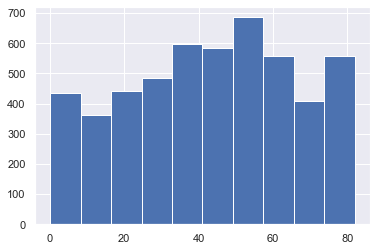

In [88]:
df['age'].hist()

In [89]:
df['age'] = pd.cut(df['age'], bins=[0, 18, 39, 59, 79, float('inf')], labels=['0-18', '18-39', '39-59', '59-79', '80+'])
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,59-79,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,59-79,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80+,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,39-59,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,59-79,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80+,1,0,Yes,Private,Urban,83.75,28.893237,never smoked,0
5106,Female,80+,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked,0
5107,Female,18-39,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked,0
5108,Male,39-59,0,0,Yes,Private,Rural,166.29,25.600000,formerly smoked,0


### Average Glucose Level

Determining a "normal" glucose level is difficult as it depends on when the patient last ate. As this data is not available, the minimum and maximum thresholds for fasting and fed states are most applicable.

Of most concern are patients at risk of or with diabetes. This could potentially be inferred from other lifestyle factors known to influence risk. We will restrict outselves however to glucose levels that are either `LOW`, `NORMAL`, or `HIGH`. The value ranges of `LOW < 70 < NORMAL < 200 < HIGH` is based on publicly available ranges for normal glucose levels.

In [90]:
df['avg_glucose_level'] = pd.cut(df['avg_glucose_level'], bins=[0, 70, 200, float('inf')], labels=['LOW', 'NORMAL', 'HIGH'])
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,59-79,0,1,Yes,Private,Urban,HIGH,36.600000,formerly smoked,1
1,Female,59-79,0,0,Yes,Self-employed,Rural,HIGH,28.893237,never smoked,1
2,Male,80+,0,1,Yes,Private,Rural,NORMAL,32.500000,never smoked,1
3,Female,39-59,0,0,Yes,Private,Urban,NORMAL,34.400000,smokes,1
4,Female,59-79,1,0,Yes,Self-employed,Rural,NORMAL,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80+,1,0,Yes,Private,Urban,NORMAL,28.893237,never smoked,0
5106,Female,80+,0,0,Yes,Self-employed,Urban,NORMAL,40.000000,never smoked,0
5107,Female,18-39,0,0,Yes,Self-employed,Rural,NORMAL,30.600000,never smoked,0
5108,Male,39-59,0,0,Yes,Private,Rural,NORMAL,25.600000,formerly smoked,0


### Body Mass Index (BMI)

BMI is a simple measure that groups people into bins of `UNDERWEIGHT`, `HEALTHY`, `OVERWEIGHT`, `OBESE`, and `MORBIDLY_OBESE`. The translation of this continuous data into categorical data follows naturally and accords with what these values represent.

In [91]:
df['bmi'] = pd.cut(df['bmi'], bins=[0, 18.5, 25, 30, 40, float('inf')], labels=['UNDERWEIGHT', 'HEALTHY', 'OVERWEIGHT', 'OBESE', 'MORBIDLY_OBESE'])
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,59-79,0,1,Yes,Private,Urban,HIGH,OBESE,formerly smoked,1
1,Female,59-79,0,0,Yes,Self-employed,Rural,HIGH,OVERWEIGHT,never smoked,1
2,Male,80+,0,1,Yes,Private,Rural,NORMAL,OBESE,never smoked,1
3,Female,39-59,0,0,Yes,Private,Urban,NORMAL,OBESE,smokes,1
4,Female,59-79,1,0,Yes,Self-employed,Rural,NORMAL,HEALTHY,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80+,1,0,Yes,Private,Urban,NORMAL,OVERWEIGHT,never smoked,0
5106,Female,80+,0,0,Yes,Self-employed,Urban,NORMAL,OBESE,never smoked,0
5107,Female,18-39,0,0,Yes,Self-employed,Rural,NORMAL,OBESE,never smoked,0
5108,Male,39-59,0,0,Yes,Private,Rural,NORMAL,OVERWEIGHT,formerly smoked,0


## 6 - Examining the Data & Baseline Assumption
<a id="6"></a>

Close to 5% of the dataset consists of patients with a clinical outcome of stroke.

`Baseline assumption`: guess 0 with the probability of the distribution of 0 in the dataset

We can also have a final look at the value counts in the data, confirming there are no outliers and everything is within expectations.

In [92]:
df = df.applymap(lambda s: s.upper() if type(s) == str else s)

In [93]:
df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [94]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,MALE,59-79,0,1,YES,PRIVATE,URBAN,HIGH,OBESE,FORMERLY SMOKED,1
1,FEMALE,59-79,0,0,YES,SELF-EMPLOYED,RURAL,HIGH,OVERWEIGHT,NEVER SMOKED,1
2,MALE,80+,0,1,YES,PRIVATE,RURAL,NORMAL,OBESE,NEVER SMOKED,1
3,FEMALE,39-59,0,0,YES,PRIVATE,URBAN,NORMAL,OBESE,SMOKES,1
4,FEMALE,59-79,1,0,YES,SELF-EMPLOYED,RURAL,NORMAL,HEALTHY,NEVER SMOKED,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,FEMALE,80+,1,0,YES,PRIVATE,URBAN,NORMAL,OVERWEIGHT,NEVER SMOKED,0
5106,FEMALE,80+,0,0,YES,SELF-EMPLOYED,URBAN,NORMAL,OBESE,NEVER SMOKED,0
5107,FEMALE,18-39,0,0,YES,SELF-EMPLOYED,RURAL,NORMAL,OBESE,NEVER SMOKED,0
5108,MALE,39-59,0,0,YES,PRIVATE,RURAL,NORMAL,OVERWEIGHT,FORMERLY SMOKED,0


In [95]:
for col in df.columns:
    print(f'---{col}---')
    print(df[col].value_counts())

---gender---
FEMALE    2994
MALE      2115
OTHER        1
Name: gender, dtype: int64
---age---
39-59    1564
18-39    1254
59-79    1190
0-18      916
80+       186
Name: age, dtype: int64
---hypertension---
0    4612
1     498
Name: hypertension, dtype: int64
---heart_disease---
0    4834
1     276
Name: heart_disease, dtype: int64
---ever_married---
YES    3353
NO     1757
Name: ever_married, dtype: int64
---work_type---
PRIVATE          2925
SELF-EMPLOYED     819
CHILDREN          687
GOVT_JOB          657
NEVER_WORKED       22
Name: work_type, dtype: int64
---Residence_type---
URBAN    2596
RURAL    2514
Name: Residence_type, dtype: int64
---avg_glucose_level---
NORMAL    3920
LOW        756
HIGH       434
Name: avg_glucose_level, dtype: int64
---bmi---
OVERWEIGHT        1610
OBESE             1485
HEALTHY           1258
MORBIDLY_OBESE     408
UNDERWEIGHT        349
Name: bmi, dtype: int64
---smoking_status---
NEVER SMOKED       1892
UNKNOWN            1544
FORMERLY SMOKED     885


## 7 - Hypothesis
<a id='7'></a>

There is a clear correlation between many of the attributes and an outcome of stroke. People are more at risk as they get older, for example. Therefore it is expected that all **decision tree classifiers outperform the baseline model**. This will be assessed by looking at different evaluation metrics.

Achieving greater `balanced accuracy` will indicate that the decision tree outperforms the statistical distribution of the classes, and has performance better than chance.

## 8 - Visualising CART, ID3, and C4.5
<a id="8"></a>

One requirement is that trees are visualised against the dataset.

In [96]:
tree = DecisionTree(DecisionTree.CART)
tree.fit(df)
tree.visualise()

age = 59-79
  avg_glucose_level = HIGH
    work_type = PRIVATE
      bmi = OBESE
        smoking_status = FORMERLY SMOKED
          heart_disease = 1
            Residence_type = URBAN
              gender = MALE
                hypertension = 0
                  ever_married = YES
                    : 1 🏆
            Residence_type = RURAL
              : 0 🏆
          heart_disease = 0
            gender = MALE
              Residence_type = RURAL
                hypertension = 0
                  ever_married = YES
                    : 0 🏆
              Residence_type = URBAN
                : 0 🏆
            gender = FEMALE
              Residence_type = RURAL
                hypertension = 0
                  ever_married = YES
                    : 1 🏆
        smoking_status = NEVER SMOKED
          hypertension = 1
            gender = MALE
              heart_disease = 0
                Residence_type = RURAL
                  ever_married = YES
                    : 0 🏆
    

In [97]:
tree = DecisionTree(DecisionTree.ID3)
tree.fit(df)
tree.visualise()

age = 59-79
  bmi = OBESE
    heart_disease = 1
      smoking_status = FORMERLY SMOKED
        hypertension = 0
          work_type = PRIVATE
            avg_glucose_level = HIGH
              Residence_type = URBAN
                gender = MALE
                  ever_married = YES
                    : 1 🏆
              Residence_type = RURAL
                : 0 🏆
            avg_glucose_level = NORMAL
              gender = MALE
                Residence_type = RURAL
                  ever_married = YES
                    : 1 🏆
              gender = FEMALE
                : 0 🏆
            avg_glucose_level = LOW
              : 1 🏆
          work_type = SELF-EMPLOYED
            avg_glucose_level = NORMAL
              Residence_type = URBAN
                : 1 🏆
              Residence_type = RURAL
                : 0 🏆
            avg_glucose_level = HIGH
              : 0 🏆
            avg_glucose_level = LOW
              : 0 🏆
          work_type = GOVT_JOB
            : 0 🏆


In [98]:
tree = DecisionTree(DecisionTree.C45)
tree.fit(df)
tree.visualise()

age = 59-79
  smoking_status = FORMERLY SMOKED
    bmi = OBESE
      work_type = PRIVATE
        avg_glucose_level = HIGH
          Residence_type = URBAN
            heart_disease = 1
              gender = MALE
                hypertension = 0
                  ever_married = YES
                    : 1 🏆
            heart_disease = 0
              : 0 🏆
          Residence_type = RURAL
            gender = MALE
              heart_disease = 0
                hypertension = 0
                  ever_married = YES
                    : 0 🏆
              heart_disease = 1
                : 0 🏆
            gender = FEMALE
              hypertension = 0
                ever_married = YES
                  heart_disease = 0
                    : 1 🏆
        avg_glucose_level = NORMAL
          hypertension = 0
            gender = MALE
              Residence_type = RURAL
                heart_disease = 1
                  ever_married = YES
                    : 1 🏆
                heart_

## 9 - Evaluating the Decision Tree Part 1: Confusion Matrix
<a id="9"></a>

`CART` concentrates on splits that maximise homogeneity in the remaining dataset. `ID3` mnimises uncertainty on each split, measured as entropy. `C4.5` extends `ID3` by accounting for the size of branches based on the distributions of attribute variables.

The confusion matrix shows mediocre performance on the part of the decision tree. There is a high number of *false negatives*. In a clinical setting this could mislabel a patient's risk factors and cause harm. It is therefore desirable to minimise this.

In [99]:
from typing import Tuple
from sklearn.model_selection import train_test_split as tts

def test_train_split(df: DataFrame, random_state=42, frac=0.8) -> Tuple[DataFrame, DataFrame]:
    train, test = tts(df, random_state=random_state, train_size=frac, stratify=df['stroke'])
    return train, test

In [100]:
train, test = test_train_split(df)

In [101]:
print(train.shape)
print(test.shape)

(4088, 11)
(1022, 11)


In [102]:
print(train['stroke'].value_counts())
print(test['stroke'].value_counts())

0    3889
1     199
Name: stroke, dtype: int64
0    972
1     50
Name: stroke, dtype: int64


In [103]:
tree_cart = DecisionTree(DecisionTree.CART)
tree_cart.fit(train)

tree_id3 = DecisionTree(DecisionTree.ID3)
tree_id3.fit(train)

tree_c45 = DecisionTree(DecisionTree.C45)
tree_c45.fit(train)

In [104]:
true_values = test[test.columns[-1]].astype(int)

pred_values_base = []
pred_values_cart = []
pred_values_id3 = []
pred_values_c45 = []

for i in range(len(test)):
    test_df = test.iloc[[i]]
    pred_values_base.append(0)
    pred_values_cart.append(tree_cart.predict(test_df))
    pred_values_id3.append(tree_id3.predict(test_df))
    pred_values_c45.append(tree_c45.predict(test_df))

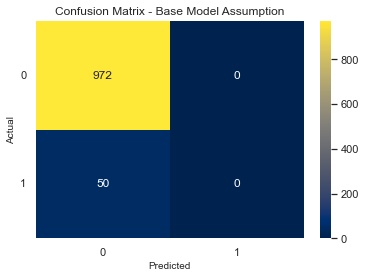

<Figure size 720x720 with 0 Axes>

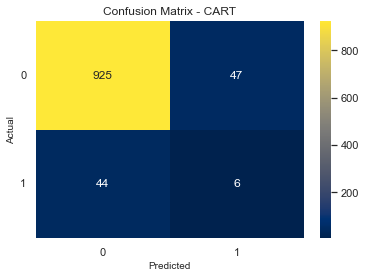

<Figure size 720x720 with 0 Axes>

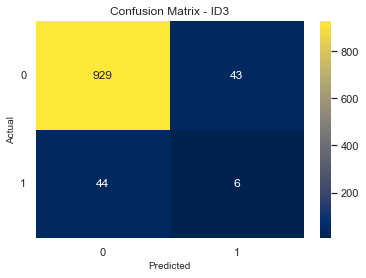

<Figure size 720x720 with 0 Axes>

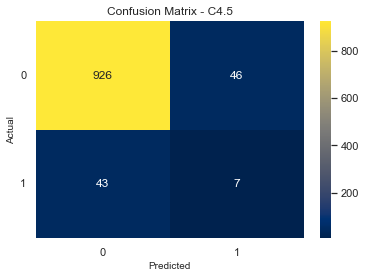

<Figure size 720x720 with 0 Axes>

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

confusion_matrix_base = metrics.confusion_matrix(true_values, pred_values_base)
confusion_matrix_cart = metrics.confusion_matrix(true_values, pred_values_cart)
confusion_matrix_id3 = metrics.confusion_matrix(true_values, pred_values_id3)
confusion_matrix_c45 = metrics.confusion_matrix(true_values, pred_values_c45)

def plot_confusion_matrix(confusion_matrix, name):
    matrix_df = pd.DataFrame(confusion_matrix)
    ax = plt.axes()

    sns.set(font_scale=1)
    plt.figure(figsize=(10,10))
    sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="cividis")

    ax.set_title(f'Confusion Matrix - {name}')
    ax.set_xlabel("Predicted", fontsize=10)
    ax.set_xticklabels([0, 1])

    ax.set_ylabel("Actual", fontsize=10)
    ax.set_yticklabels([0, 1], rotation=0)

    plt.show()

plot_confusion_matrix(confusion_matrix_base, 'Base Model Assumption')
plot_confusion_matrix(confusion_matrix_cart, 'CART')
plot_confusion_matrix(confusion_matrix_id3, 'ID3')
plot_confusion_matrix(confusion_matrix_c45, 'C4.5')

## 10 - Evaluating the Decision Tree Part 2: Learning Curve
<a id="10"></a>

We can test the performance of the decision tree again different proportions of training data, then plot the learning curve. This shows the extent to which `CART`, `ID3`, and `C4.5` fit the training data to the test data. It runs $98$ tests with a proportion of training data from $1-99%$. On each iteration, the rest of the data is used for testing.

This illustrates the case for tree pruning. Two approaches to this are early-stopping (ending branch generation early), or a statistical test called a `significance test` that evaluates and prunes decision nodes after generation. This helps avoid overfitting, which decision trees are prone to.

In [106]:
def get_learning_curve(data: DataFrame):
    def learning_curve(tree: DecisionTree):
        t, p = [], []
        for training_set_proportion in range(1, 100):
            train, test = test_train_split(data, frac=training_set_proportion / 100)
            true_values, pred_values = list(test[test.columns[-1]].astype(int)), []

            tree.fit(train)

            for i in range(len(test)):
                test_sample = test.iloc[[i]]
                pred_values.append(tree.predict(test_sample))

            t.append(true_values)
            p.append(pred_values)
        return t, p
    return learning_curve

## 11 - Performance Considerations and Time Complexity of Decision Trees
<a id="11"></a>

Time complexity is logarithmic and depends on the number of attributes (features) and values (dimensions), $O(n \log n * d)$.

Performance is a concern at this stage with this many iterations, however it remains manageable. Early stopping or a simple maximum branch depth could be useful here.

In [107]:
learning_curve = get_learning_curve(df)
t_cart, p_cart = learning_curve(DecisionTree(DecisionTree.CART))
t_id3, p_id3 = learning_curve(DecisionTree(DecisionTree.ID3))
t_c45, p_c45 = learning_curve(DecisionTree(DecisionTree.C45))

In [108]:
def determine_score(t, p, fn):
    accuracies = []
    for i in range(len(t)):
        accuracies.append(fn(t[i], p[i]))
    return accuracies

In [109]:
import matplotlib.pyplot as plt
from random import seed, random

zero_guess_proportion = len(df['stroke'][df['stroke'] == 0]) / len(df['stroke'])
baselines_guesses = []
for i in range(len(t_cart)):
    baseline = []
    for j in range(len(t_cart[i])):
        seed(f'{j}{i}')
        rand = random()
        guess = 0 if rand < zero_guess_proportion else 1
        baseline.append(guess)
    baselines_guesses.append(baseline)

In [110]:
from sklearn.metrics import f1_score, balanced_accuracy_score, recall_score, precision_score

def helper(fn):
    def wrapper(t, p):
        return determine_score(t, p, fn)
    return wrapper

f1_fn = helper(f1_score)
balanced_accuracy_fn = helper(balanced_accuracy_score)
recall_fn = helper(recall_score)
precision_fn = helper(precision_score)

fns = (f1_fn, balanced_accuracy_fn, recall_fn, precision_fn)

scores = []
for fn in fns:
    scores.append((fn(t_cart, baselines_guesses), fn(t_cart, p_cart), fn(t_id3, p_id3), fn(t_c45, p_c45)))

## 12 - Metrics and Discussion
<a id="12"></a>

By all accounts, each decision tree outperforms the baseline model. As established in the [Hypothesis](#7), *false negatives* are of particular concern. Therefore recall is the most salient metric to gauge real-world performance.

The performance of each decision tree is similar. Notably, the `C4.5` algorithm has lower variance in performance by virtue of $SplitInformation's$ influence on split decisions. However it performs poorer than `CART` and `ID3` until the training set proportion reaches $80%$, where it excels. This is likely negatively affected by the absence of tree pruning.

Overall the performance of the decision tree illustrates that there is a pattern in the features that correlates with the outcome classes. However the magnitude of this correlation, as derived by these implementations, is not significant.

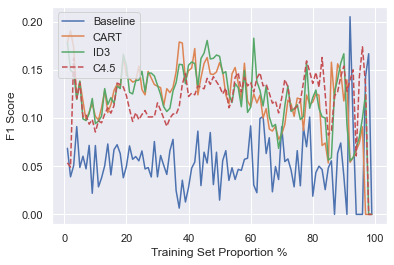

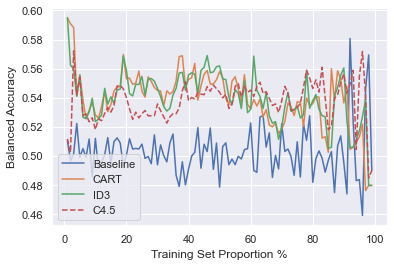

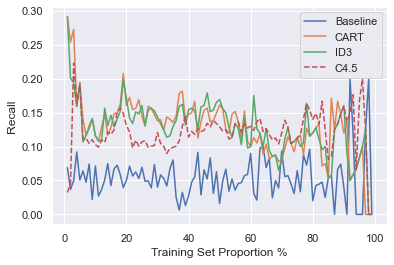

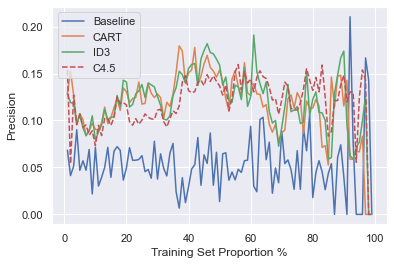

In [111]:
def show_plot(
    values,
    y_label,
    x_label,
    linestyles=("-", "-", "-", "--"),
    labels=("Baseline", "CART", "ID3", "C4.5"),
):
    for key, value in enumerate(values):
        plt.plot(
            [i + 1 for i in range(len(value))],
            value,
            label=labels[key],
            linestyle=linestyles[key],
        )

    plt.ylabel(y_label)
    plt.xlabel(x_label)

    plt.legend()
    plt.show()

y_labels = ("F1 Score", "Balanced Accuracy", "Recall", "Precision")
x_label = 'Training Set Proportion %'
for key, value in enumerate(scores):
    show_plot(value, y_labels[key], x_label)

## 13 - Mathematical Definitions
<a id="13"></a>

$ \text {GiniImpurity}=1-\sum_{i=1}^{N} p_{i}^{2} $

$ \text {Entropy} = \sum_{i=1}^{c}-p_{i} \log _{2} p_{i} $

$ \text {InformationGain}=\text { Entropy }(\text { all samples })-\sum_{i=1}^{N} \text { Entropy }(i, \text { samples after split }) $

$ \operatorname{SplitInformation}(Samples)=-\sum_{i=1}^{n} \frac{\mathrm{Count}\left(e_{i}\right)}{\mathrm{Count}(e)} * \log _{2} \frac{\mathrm{Count}\left(e_{i}\right)}{\mathrm{Count}(e)} $

$ \text {InformationGainRatio}=\frac{\text {InformationGain}}{\text {SplitInformation}} $